#  Advanced Flower Image Classification
This notebook explores various machine learning techniques for image classification using a dataset of flower images.

In [1]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings("ignore")


##  Load and Preprocess Images

In [2]:

IMAGE_SIZE = (32, 32)
DATASET_PATH = "flowers"
CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

def load_image_data():
    data = []
    labels = []
    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path).convert('L')
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img).flatten()
                    # Feature Engineering: add mean and std dev of pixels
                    avg_pixel = np.mean(img_array)
                    std_pixel = np.std(img_array)
                    img_array = np.append(img_array, [avg_pixel, std_pixel])
                    data.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    df = pd.DataFrame(data)
    df['label'] = labels
    return df

df = load_image_data()
X = df.drop("label", axis=1).values
y_raw = df["label"].values
le = LabelEncoder()
y = le.fit_transform(y_raw)


## 🔧 Data Preprocessing: Normalization & Standardization

In [3]:

# Normalize pixel values
X = X / 255.0

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 🧠 Advanced Feature Engineering: PCA, Polynomial & Feature Selection

In [4]:

# PCA: reduce to 150 components
pca = PCA(n_components=150)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_pca)
X_test_poly = poly.transform(X_test_pca)

# Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_selected = selector.fit_transform(X_poly, y_train)
X_test_selected = selector.transform(X_test_poly)


## 📊 Visualization Utilities

In [5]:

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = sk_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_model_metrics(metrics_dict):
    labels = list(metrics_dict.keys())
    accuracy = [v['accuracy'] for v in metrics_dict.values()]
    precision = [v['precision'] for v in metrics_dict.values()]
    recall = [v['recall'] for v in metrics_dict.values()]
    x = np.arange(len(labels))
    width = 0.25
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, accuracy, width, label='Accuracy')
    plt.bar(x, precision, width, label='Precision')
    plt.bar(x + width, recall, width, label='Recall')
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Score")
    plt.title("Comparison of Models")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 🤖 Model Definitions and Evaluation
> In the next part we will define upgraded versions of our four main models:
- KNN with custom distance
- Logistic Regression with regularization
- SVM with tuning
- Naive Bayes with selected features

Then we will compare all models and add an ensemble voting classifier.

## 🤖 Upgraded Model Definitions and Grid Search

In [6]:

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import time

# --- 1) KNN with custom Manhattan distance and Grid Search for k
from sklearn.neighbors import KNeighborsClassifier

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b), axis=1)

# We'll wrap KNeighborsClassifier with our custom distance via 'metric' param = 'manhattan'
knn_params = {'n_neighbors': [3,5,7,9],
              'weights': ['uniform','distance']}

knn_model = KNeighborsClassifier(metric='manhattan')
knn_grid = GridSearchCV(knn_model, knn_params, cv=3, n_jobs=-1)

# --- 2) Logistic Regression w/ L2 + Grid Search for C
from sklearn.linear_model import LogisticRegression

log_params = {'C': [0.01, 0.1, 1, 10],
              'max_iter': [500, 1000]}

log_model = LogisticRegression(solver='lbfgs', penalty='l2')
log_grid = GridSearchCV(log_model, log_params, cv=3, n_jobs=-1)

# --- 3) SVM w/ RBF + Grid Search
from sklearn.svm import SVC

svm_params = {'C': [0.01, 0.1, 1, 10],
              'gamma': ['scale','auto']}
svm_model = SVC(kernel='rbf')
svm_grid = GridSearchCV(svm_model, svm_params, cv=3, n_jobs=-1)

# --- 4) Naive Bayes w/ PCA + selected features (already done in stage1, let's just wrap it)
# Actually we can do a simple GaussianNB but it's not typically set with many hyperparams
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

# We'll keep it simple for NB (no grid search).


## 🏋️ Training and Comparing Models with Grid Search

In [7]:

# We'll use X_selected and X_test_selected from the advanced feature pipeline
X_tr = X_selected
X_te = X_test_selected

models_scores = {}

# KNN
start = time.time()
knn_grid.fit(X_tr, y_train)
end = time.time()
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_te)
knn_acc = np.mean(y_pred_knn == y_test)

from sklearn.metrics import precision_score, recall_score
knn_prec = precision_score(y_test, y_pred_knn, average='macro')
knn_rec = recall_score(y_test, y_pred_knn, average='macro')

models_scores['KNN'] = {
    'accuracy': knn_acc,
    'precision': knn_prec,
    'recall': knn_rec,
    'train_time': end - start,
    'best_params': knn_grid.best_params_
}

print(f"=== KNN ===\nBest Params: {knn_grid.best_params_}\nAccuracy: {knn_acc:.3f}, Precision: {knn_prec:.3f}, Recall: {knn_rec:.3f}, Train Time: {end - start:.2f}s")


# Logistic Regression
start = time.time()
log_grid.fit(X_tr, y_train)
end = time.time()
best_log = log_grid.best_estimator_
y_pred_log = best_log.predict(X_te)
log_acc = np.mean(y_pred_log == y_test)
log_prec = precision_score(y_test, y_pred_log, average='macro')
log_rec = recall_score(y_test, y_pred_log, average='macro')

models_scores['Logistic'] = {
    'accuracy': log_acc,
    'precision': log_prec,
    'recall': log_rec,
    'train_time': end - start,
    'best_params': log_grid.best_params_
}

print(f"\n=== Logistic Regression ===\nBest Params: {log_grid.best_params_}\nAccuracy: {log_acc:.3f}, Precision: {log_prec:.3f}, Recall: {log_rec:.3f}, Train Time: {end - start:.2f}s")


# SVM
start = time.time()
svm_grid.fit(X_tr, y_train)
end = time.time()
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_te)
svm_acc = np.mean(y_pred_svm == y_test)
svm_prec = precision_score(y_test, y_pred_svm, average='macro')
svm_rec = recall_score(y_test, y_pred_svm, average='macro')

models_scores['SVM'] = {
    'accuracy': svm_acc,
    'precision': svm_prec,
    'recall': svm_rec,
    'train_time': end - start,
    'best_params': svm_grid.best_params_
}

print(f"\n=== SVM ===\nBest Params: {svm_grid.best_params_}\nAccuracy: {svm_acc:.3f}, Precision: {svm_prec:.3f}, Recall: {svm_rec:.3f}, Train Time: {end - start:.2f}s")


# Naive Bayes
# We assume no grid search for NB
start = time.time()
nb_model.fit(X_tr, y_train)
end = time.time()
y_pred_nb = nb_model.predict(X_te)
nb_acc = np.mean(y_pred_nb == y_test)
nb_prec = precision_score(y_test, y_pred_nb, average='macro')
nb_rec = recall_score(y_test, y_pred_nb, average='macro')

models_scores['Naive Bayes'] = {
    'accuracy': nb_acc,
    'precision': nb_prec,
    'recall': nb_rec,
    'train_time': end - start,
    'best_params': None
}

print(f"\n=== Naive Bayes ===\nAccuracy: {nb_acc:.3f}, Precision: {nb_prec:.3f}, Recall: {nb_rec:.3f}, Train Time: {end - start:.2f}s")



=== KNN ===
Best Params: {'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.285, Precision: 0.297, Recall: 0.247, Train Time: 4.34s

=== Logistic Regression ===
Best Params: {'C': 0.01, 'max_iter': 500}
Accuracy: 0.302, Precision: 0.277, Recall: 0.272, Train Time: 1.58s

=== SVM ===
Best Params: {'C': 1, 'gamma': 'scale'}
Accuracy: 0.331, Precision: 0.295, Recall: 0.288, Train Time: 5.35s

=== Naive Bayes ===
Accuracy: 0.331, Precision: 0.298, Recall: 0.294, Train Time: 0.00s


## 📊 Visualization of Each Model's Confusion Matrix

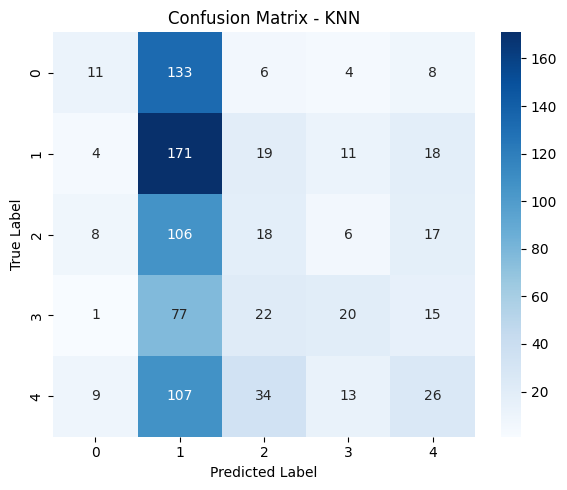

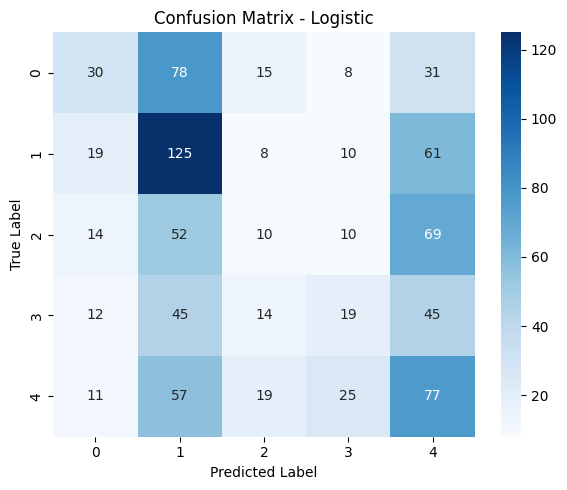

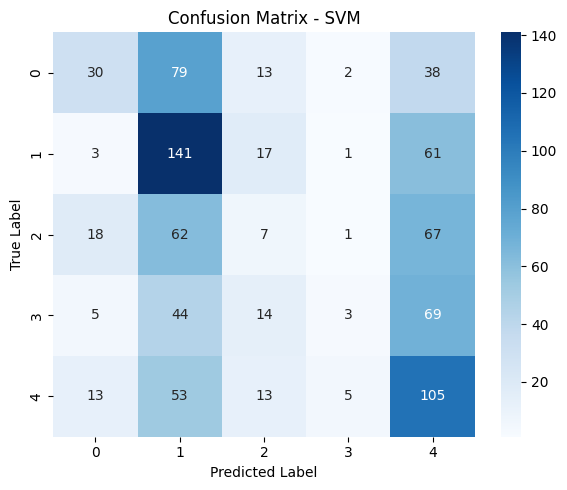

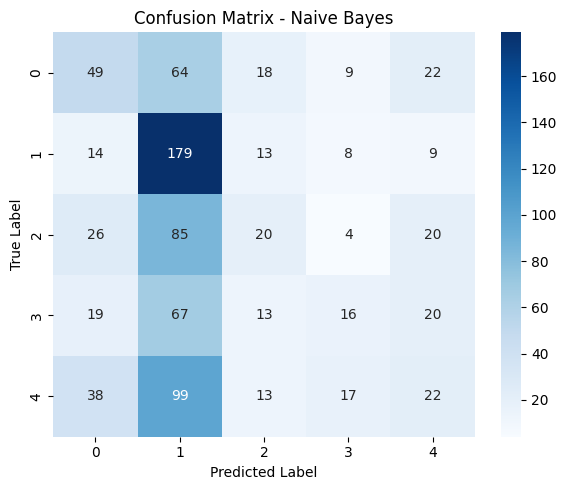

In [8]:

from sklearn.metrics import confusion_matrix

for model_name, score_info in models_scores.items():
    if model_name == 'KNN':
        y_pred = y_pred_knn
    elif model_name == 'Logistic':
        y_pred = y_pred_log
    elif model_name == 'SVM':
        y_pred = y_pred_svm
    else:
        y_pred = y_pred_nb

    plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix - {model_name}")


## 🤝 Ensemble Voting Classifier


=== Voting Ensemble ===
Accuracy: 0.324, Precision: 0.303, Recall: 0.281


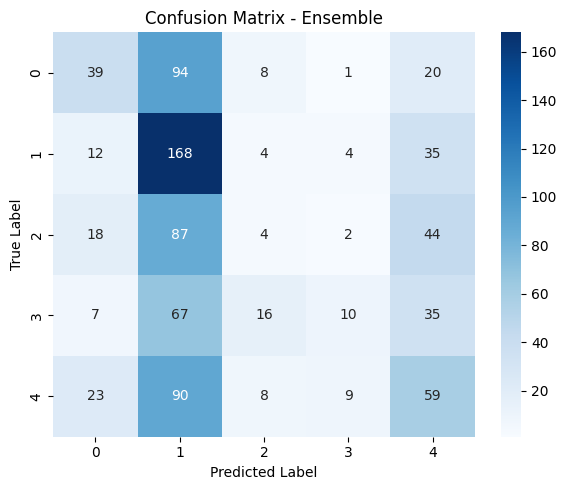

In [9]:

ensemble = VotingClassifier(estimators=[
    ('knn', best_knn),
    ('logistic', best_log),
    ('svm', best_svm),
    ('nb', nb_model)
], voting='hard')
ensemble.fit(X_tr, y_train)
y_pred_ens = ensemble.predict(X_te)

ens_acc = np.mean(y_pred_ens == y_test)
ens_prec = precision_score(y_test, y_pred_ens, average='macro')
ens_rec = recall_score(y_test, y_pred_ens, average='macro')

models_scores['Ensemble'] = {
    'accuracy': ens_acc,
    'precision': ens_prec,
    'recall': ens_rec,
    'train_time': None,
    'best_params': None
}

print(f"\n=== Voting Ensemble ===\nAccuracy: {ens_acc:.3f}, Precision: {ens_prec:.3f}, Recall: {ens_rec:.3f}")
plot_confusion_matrix(y_test, y_pred_ens, title="Confusion Matrix - Ensemble")


## 📈 Compare All Models

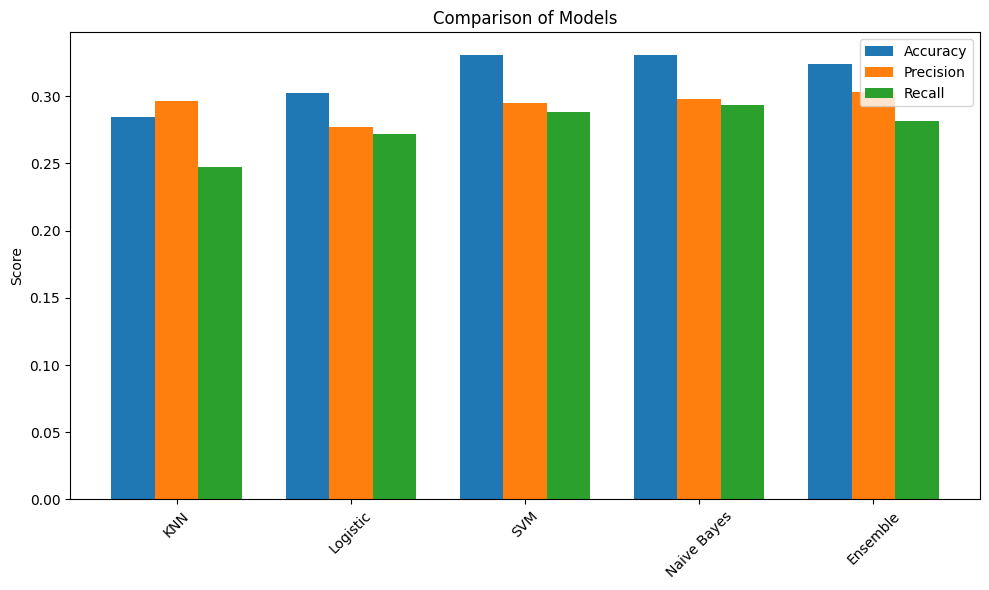

In [10]:

# Convert to dict suitable for plot_model_metrics
plot_dict = {}
for model_name, info in models_scores.items():
    plot_dict[model_name] = {
        'accuracy': info['accuracy'],
        'precision': info['precision'],
        'recall': info['recall']
    }

plot_model_metrics(plot_dict)
